In [1]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# If you need to determine the percent voxel change between two images follow these steps first. 

## If you already have a "percent.csv" file, skip to next section

In [4]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"
affinefile = os.path.join(src, "output_dirs/Chon_to_PRA_affine/result.tif")
transformixedfile = os.path.join(src, "output_dirs/Chon_for_PRA/result.tif")
annotationsfilename = os.path.join(src,"labels/chon_label_ids.csv")
voxcsv = os.path.join(src,"Chon_to_PRA_vox.csv")
percentcsv = os.path.join(src,"Chon_to_PRA_percent.csv")
transformixed_relative_ZEROED_tiff = os.path.join(src,"Chon_to_PRA_relative_ZEROED_tiff.tif")
transformixed_relative_tiff = os.path.join(src,"Chon_to_PRA_relative_tiff.tif")

In [5]:
affine = tif.imread(affinefile)
print("read affine tiff")
transformixed = tif.imread(transformixedfile)
print("read transformixed tiff")

read affine tiff
read transformixed tiff


In [6]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1],header=0,names=['id','abbr'])
print("read annotations")

read annotations


In [7]:
df=anns.dropna()
df

,id,abbr
0,8.0,grey
1,567.0,CH
2,688.0,CTX
3,695.0,CTXpl
4,315.0,Isocortex
...,...,...
1632,11.0,plf
1635,34.0,icf
1636,43.0,apmf
1639,65.0,pfs


In [8]:
df.insert(2,'affine_vox',0)
df.insert(3,'transformixed_vox',0)

In [16]:
for i in df['id']:
    df.transformixed_vox[i] = np.size(transformixed[transformixed==df.id[i]])
    df.affine_vox[i] = np.size(affine[affine==df.id[i]])

<ipython-input-16-5b4b09f8b678>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transformixed_vox[i] = np.size(transformixed[transformixed==df.id[i]])
/home/emilyjanedennis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-16-5b4b09f8b678>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.affin

KeyError: 2325

In [17]:
df['change'] = df['affine_vox']-df['transformixed_vox']

<ipython-input-17-2b5f6338f5d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] = df['affine_vox']-df['transformixed_vox']


In [18]:
df

,id,abbr,affine_vox,transformixed_vox,change
0,8.0,grey,13873,15191,-1318
1,567.0,CH,20194,20479,-285
2,688.0,CTX,18522,19229,-707
3,695.0,CTXpl,21114,21332,-218
4,315.0,Isocortex,15392,15766,-374
...,...,...,...,...,...
1632,11.0,plf,0,0,0
1635,34.0,icf,0,0,0
1636,43.0,apmf,0,0,0
1639,65.0,pfs,0,0,0


In [19]:
df = df[df.transformixed_vox > 0]
df

,id,abbr,affine_vox,transformixed_vox,change
0,8.0,grey,13873,15191,-1318
1,567.0,CH,20194,20479,-285
2,688.0,CTX,18522,19229,-707
3,695.0,CTXpl,21114,21332,-218
4,315.0,Isocortex,15392,15766,-374
...,...,...,...,...,...
315,886.0,A29 (RSG),18905,20525,-1620
567,2442.0,STr-sp,208562,210648,-2086
667,559.0,CeM,63211,59210,4001
688,2028.0,B,15658,16399,-741


In [21]:
dfpercent = (df['change']/df['transformixed_vox'])*100
dfpercent[np.isinf(dfpercent)]=0
df['percent'] = dfpercent
dfpercent.replace(0,np.nan)

<ipython-input-21-fce1c83d1c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent'] = dfpercent


0     -8.676190
1     -1.391670
2     -3.676738
3     -1.021939
4     -2.372193
         ...   
315   -7.892814
567   -0.990278
667    6.757305
688   -4.518568
695    8.863180
Length: 148, dtype: float64

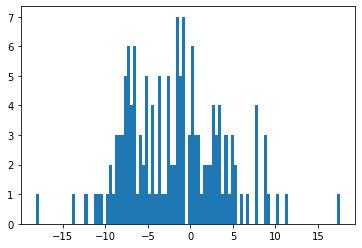

In [22]:
plt.hist(df.percent,bins=100)
plt.show()

In [23]:
mp = np.nanmedian(df.percent)
sp = np.nanstd(df.percent)

In [24]:
highmp = mp+sp
highmp

4.079670511872287

In [25]:
lowmp = mp-sp
lowmp

-7.207609298626705

In [26]:
df.to_csv(percentcsv)

In [27]:
df=pd.read_csv(percentcsv)

In [28]:
df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,8.0,grey,13873,15191,-1318,-8.676190
1,1,567.0,CH,20194,20479,-285,-1.391670
2,2,688.0,CTX,18522,19229,-707,-3.676738
3,3,695.0,CTXpl,21114,21332,-218,-1.021939
4,4,315.0,Isocortex,15392,15766,-374,-2.372193
...,...,...,...,...,...,...,...
143,315,886.0,A29 (RSG),18905,20525,-1620,-7.892814
144,567,2442.0,STr-sp,208562,210648,-2086,-0.990278
145,667,559.0,CeM,63211,59210,4001,6.757305
146,688,2028.0,B,15658,16399,-741,-4.518568


In [33]:
too = df.id
too

0         8.0
1       567.0
2       688.0
3       695.0
4       315.0
        ...  
143     886.0
144    2442.0
145     559.0
146    2028.0
147    2293.0
Name: id, Length: 148, dtype: float64

In [30]:
transformixed_relative = transformixed

In [31]:
# add list of unique values not in twoxh/twoxl but in transformixed
x = np.unique(transformixed)
np.size(x)

10738

In [32]:
test = np.setdiff1d(x,too)
np.size(test)

10590

In [34]:
for i in test:
    transformixed_relative[transformixed_relative==i]=0

In [35]:
tif.imsave(transformixed_relative_ZEROED_tiff,transformixed_relative)

In [36]:
for i in too:
    transformixed_relative[transformixed_relative==i]=df.loc[df['id']==i,'percent'].iloc[0]

In [37]:
tif.imsave(transformixed_relative_tiff,transformixed_relative)

# If you already have a percent file

In [38]:
df=pd.read_csv(percentcsv)

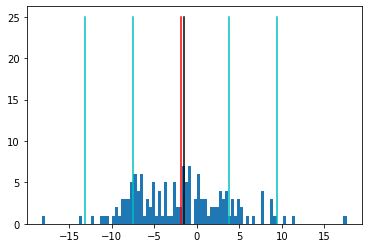

In [39]:
plt.hist(df.percent[df.affine_vox>5],bins=100)

dfmean = np.nanmean(df.percent[df.affine_vox>5])
dfmedian = np.nanmedian(df.percent[df.affine_vox>5])
dfstd = np.std(df.percent[df.affine_vox>5])
mp = dfmean + dfstd
mm = dfmean - dfstd

mp2 = dfmean + 2*dfstd
mp3 = dfmean + 3*dfstd
mm2 = dfmean - 2*dfstd
mm3 = dfmean - 3*dfstd


plt.plot([dfmean, dfmean],[0,25],'r')
plt.plot([dfmedian, dfmedian],[0,25],'k')
plt.plot([mp,mp],[0,25],'c')
plt.plot([mm,mm],[0,25],'c')
plt.plot([mp2,mp2],[0,25],'c')
plt.plot([mm2,mm2],[0,25],'c')
plt.show()

In [40]:
# want to make summary -- ideally show a ranked 3, 2, 1std>mean 
# in diff colors, and then the 
# values either written or in bar form on the right

df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,8.0,grey,13873,15191,-1318,-8.676190
1,1,567.0,CH,20194,20479,-285,-1.391670
2,2,688.0,CTX,18522,19229,-707,-3.676738
3,3,695.0,CTXpl,21114,21332,-218,-1.021939
4,4,315.0,Isocortex,15392,15766,-374,-2.372193
...,...,...,...,...,...,...,...
143,315,886.0,A29 (RSG),18905,20525,-1620,-7.892814
144,567,2442.0,STr-sp,208562,210648,-2086,-0.990278
145,667,559.0,CeM,63211,59210,4001,6.757305
146,688,2028.0,B,15658,16399,-741,-4.518568


In [51]:
df2p = df[df.percent>mp2]
df2p = df2p.sort_values('percent',ascending=False)
df2m = df[df.percent < mm2]
df2m = df2m.sort_values('percent',ascending=False)

In [52]:
df2m

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
101,101,806.0,S2-2/3,210098,243105,-33007,-13.577261
142,184,2411.0,V2ML-5,58055,70962,-12907,-18.188608


In [53]:
df2p

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
76,76,2357.0,S1DZO-6a,7508,6384,1124,17.606516
16,16,2017.0,FrC3,8436,7580,856,11.292876
42,42,2344.0,S1J-6b,18702,16975,1727,10.173785


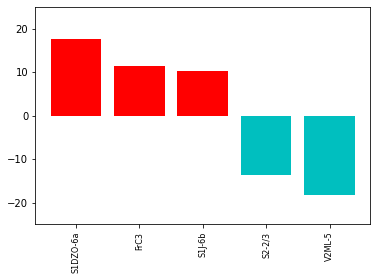

In [54]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=8)
plt.ylim([-25,25])
plt.show()

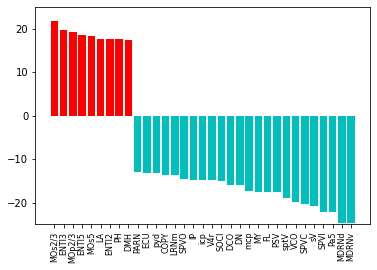

In [54]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=8)
plt.ylim([-25,25])
plt.show()